# Проект "Компьютер говорит "Нет""
Задача - построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Результаты оцениваются по площади под кривой ROC AUC.

# Импорт библиотек и файлов

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
df_test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')


In [3]:
# Для корректной обработки обьединяем данные
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['default'] = 0 

df = df_test.append(df_train, sort=False).reset_index(drop=True)

# Вспомогательные функции

In [4]:
def IQR(pd_dataset, column_name, bins_n=10, feature_name=None):
    """ 
       Функция для расчета и визуализации границ выбросов.
       Выводит параметры квантилей и гистограммы распределения и boxplot
    """
    data_column = pd_dataset[column_name]
    percents_25 = data_column.quantile(0.25, interpolation="midpoint")
    percents_75 = data_column.quantile(0.75, interpolation="midpoint")
    IQR = percents_75 - percents_25
    print(f'Q1: {percents_25}\nQ3: {percents_75}\nIQR: {IQR}',
          f'\nГраница выбросов: [{percents_25 - 1.5*IQR}, {percents_75 + 1.5*IQR}]')
    print("Пропущено значений:", data_column.isna().sum())
    
    # гистограмма распределения: 
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.distplot(data_column.values, bins=bins_n, color='#50248f')
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
    plt.ylabel('Quantity (frequency)')

    # boxplot: 
    plt.subplot(122)
    sns.boxplot(data_column.values, color='#38d1ff')  
    plt.title(column_name + ' Distribution - full dataset\n', fontsize=15)
    plt.xlabel(column_name)
    plt.show()
    
    if feature_name is not None:
        
        # гистограмма распределения: 
        plt.figure(figsize=(15, 4))
        plt.subplot(121)
        sns.distplot(np.log(data_column.values+1), bins=bins_n, color='#a1c9e0')
        plt.title(' логарифм от ' + column_name, fontsize=15)
        plt.xlabel(column_name)
        plt.ylabel('Quantity (frequency)')
        
        # boxplot: распределение признака по целевой переменной
        plt.subplot(122)
        sns.boxplot(x=pd_dataset['default'], y=pd_dataset[column_name])
        plt.title(column_name + ' distribution by default', fontsize=15)
        plt.xlabel('default')
        plt.ylabel(column_name)
        
        plt.show()
    return ''

# Ищем самые значимые признаки среди числовых
def important_cols(cols, data):
  imp_num = pd.Series(f_classif(data.query('sample == 1')[cols], data.query('sample == 1')['default'])[0], index = cols)
  imp_num.sort_values(inplace = True)
  imp_num.plot(kind = 'barh', figsize=(15,10))
  return ''

# Функция для заполнения выбросов ближайшим квантилем
def fill_quantile(data, col, quant): #quantile=0.25 или 0.75
    IQR = data[col].quantile(q=0.75) - data[col].quantile(0.25)
    perc_25 = data[col].quantile(0.25)
    perc_75 = data[col].quantile(0.75)
    high_border = perc_75 + 1.5*IQR
    low_border = perc_25 - 1.5*IQR
    if quant == 0.75:
        data[col] = data[col].apply(lambda x: perc_75 if x>perc_75 else x)
    elif quant == 0.25:
        data[col] = data[col].apply(lambda x: perc_25 if x<perc_25 else x)
    else:
        print('Значение квантиля должно быть 0.25 или 0.75 :)')
    return data

# Функция для анализа квантилей и выбросов
def func_quantile(data, col):   
    
    IQR = data[col].quantile(q=0.75) - data[col].quantile(0.25)
    perc_25 = data[col].quantile(0.25)
    perc_75 = data[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc_25), '75-й перцентиль: {},'.format(perc_75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc_25 - 1.5*IQR, l=perc_75 + 1.5*IQR))
    
    # Подсчет количества выбросов
    print("Количество выбросов в столбце",col,":",data[data[col]<perc_25 - 1.5*IQR][col].count() + data[data[col]>perc_75 + 1.5*IQR][col].count())
    data[col].loc[data[col].between(perc_25 - 1.5*IQR, perc_75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

# Функция анализа категориальных переменных
def category(data, col):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    sns.distplot(data[col].values, bins=7, color='#a1c9e0')
    plt.title(' распределение ' + col, fontsize=15)
    plt.xlabel(col)
    plt.ylabel('Quantity (frequency)')
            
    # boxplot: распределение признака по целевой переменной
    plt.subplot(122)
    sns.boxplot(x=data.query('sample == 1')['default'], y=data.query('sample == 1')[col])
    plt.title(col + ': distribution by default', fontsize=15)
    plt.xlabel('default')
    plt.ylabel(col)
    plt.show()

# Функция определения значимых признаков

def important_feature(data, col, key):
    cols = data.loc[:, col].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, col] == comb[0], key],
                     data.loc[data.loc[:, column] == comb[1], key]).pvalue \
                <= 0.05/len(combinations_all):
            print('обнаружена статистическая значимость измерения: ', col)
            break

# Предварительный обзор данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
# Наличие пропусков и дубликатов в DataFrame

print(df.isna().sum())
print('Дубликатов:', df.duplicated().sum())
print('Количество пропусков:', df['default'].isnull().sum())

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64
Дубликатов: 0
Количество пропусков: 0


In [7]:
# Первые 10 уникальных значений
df_agg = df.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(df.isnull().sum(), name='null'))\
    .append(pd.Series(df.dtypes, name='dtype'))\
    .transpose()

df_agg

,nunique,<lambda>,null,dtype
client_id,110148,"[74835, 17527, 75683, 26883, 28862, 99881, 266...",0,int64
app_date,120,"[22MAR2014, 24JAN2014, 23MAR2014, 03FEB2014, 0...",0,object
education,5,"[GRD, SCH, UGR, PGR, nan, ACD]",478,object
sex,2,"[M, F]",0,object
age,52,"[29, 39, 50, 56, 38, 55, 30, 41, 34, 28]",0,int64
car,2,"[Y, N]",0,object
car_type,2,"[Y, N]",0,object
decline_app_cnt,24,"[0, 5, 3, 1, 2, 6, 4, 8, 10, 7]",0,int64
good_work,2,"[0, 1]",0,int64
score_bki,102618,"[-2.27188367, -1.50499915, -1.69133904, -2.374...",0,float64


0    100776
1      9372
Name: default, dtype: int64

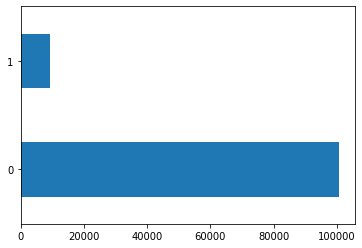

In [8]:
# соотношение наличия или отсутвия дефолта у клиента
df['default'].value_counts().plot.barh()
df['default'].value_counts()

In [9]:
#бинарные переменные
bin_cols=['sex','car','car_type','good_work','foreign_passport']

#категориальные переменные
cat_cols=['education','home_address','work_address','app_date','sna'] 

#числовые переменные
num_cols=['age','decline_app_cnt','income','bki_request_cnt','score_bki','region_rating','first_time']

У нас есть 18 признаков разных типов: категориальные, бинарные и числовые. Присутствуют пропуски в признаке 'education', а дубликаты отсутствуют.

Первоначальная версия датасета состоит из девятнадцати столбцов, содержащих следующую информацию: client_id: идентификатор клиента;

education: уровень образования;

sex: пол заёмщика;

age: возраст заёмщика;

car: флаг наличия автомобиля;

car_type: флаг автомобиля-иномарки;

decline_app_cnt: количесвто отказанных прошлых заявок;

good_work: флаг наличия "хорошей" работы;

bki_request_cnt: количество запросов в БКИ(Бюро кредитных историй);

home_adress: категоризатор домашнего адреса;

work_adress: категоризатор рабочего адреса;

income: доход заёмщика;

foreign_passport: наличие загранпаспорта;

sna - связь заемщика с клиентами банка;

first_time - давность наличия информации о заемщике;

score_bki - скоринговый балл по данным из БКИ;

region_rating - рейтинг региона;

app_date - дата подачи заявки;

default: наличие дефолта;

# Числовые переменные

Q1: 30.0
Q3: 48.0
IQR: 18.0 
Граница выбросов: [3.0, 75.0]
Пропущено значений: 0


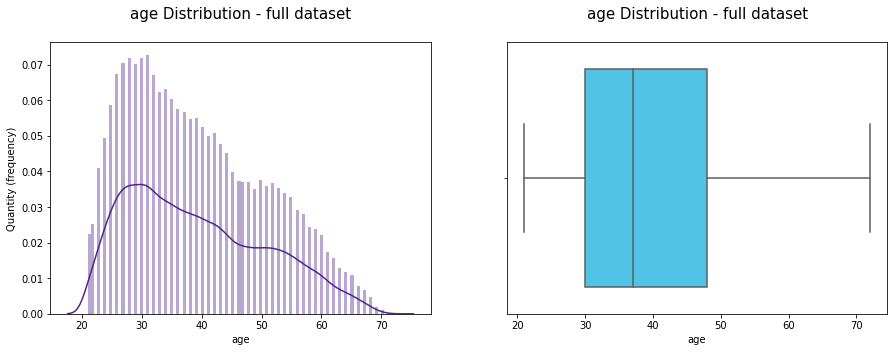

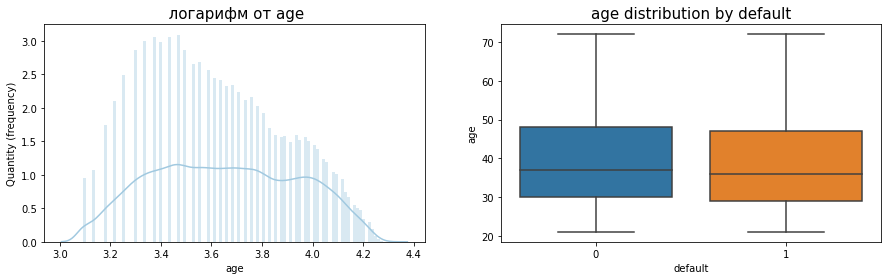

Q1: 0.0
Q3: 0.0
IQR: 0.0 
Граница выбросов: [0.0, 0.0]
Пропущено значений: 0


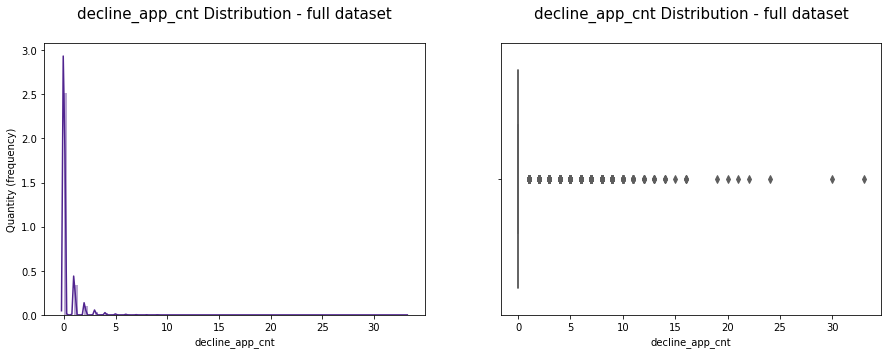

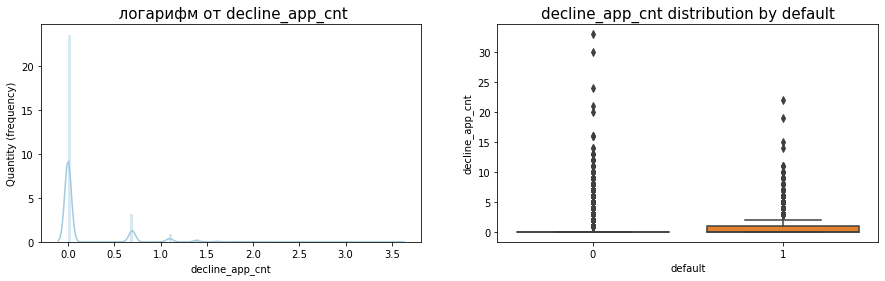

Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Граница выбросов: [-22000.0, 90000.0]
Пропущено значений: 0


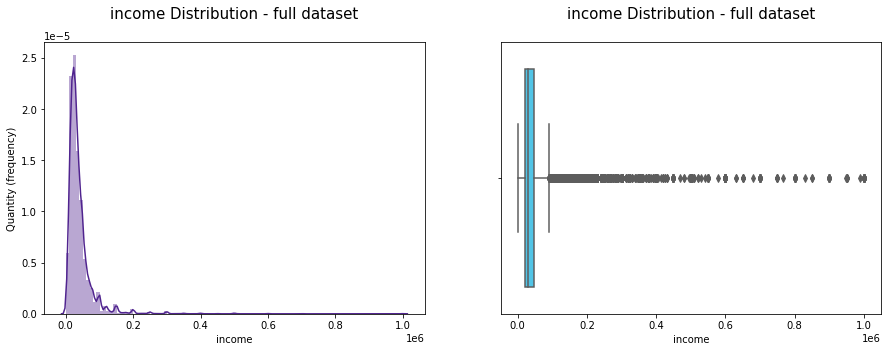

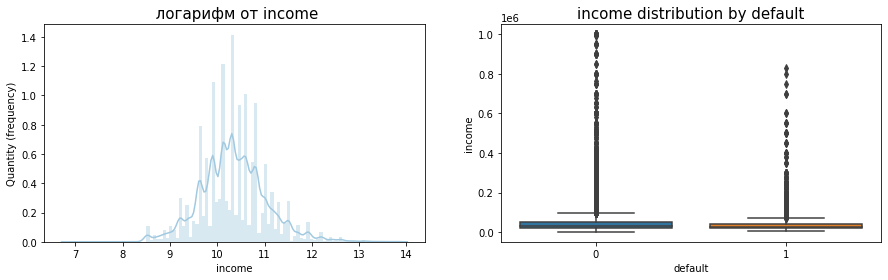

Q1: 0.0
Q3: 3.0
IQR: 3.0 
Граница выбросов: [-4.5, 7.5]
Пропущено значений: 0


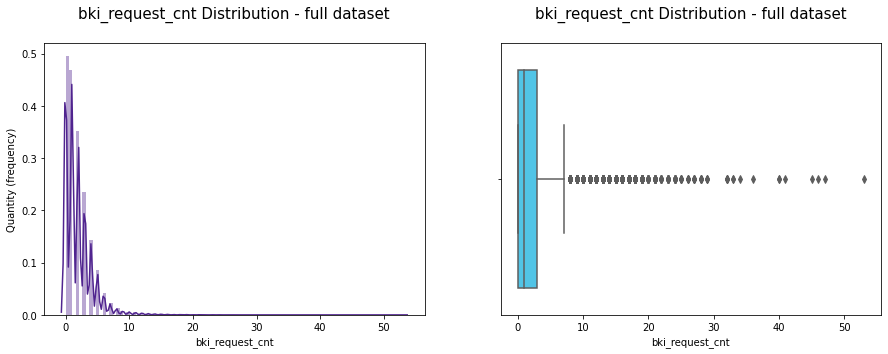

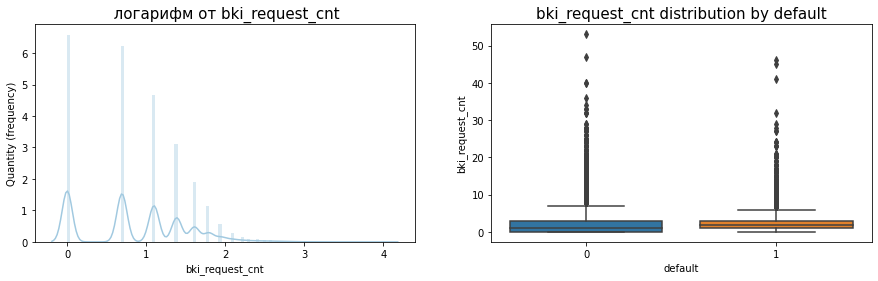

Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Граница выбросов: [-3.2992757525, -0.5290490524999998]
Пропущено значений: 0


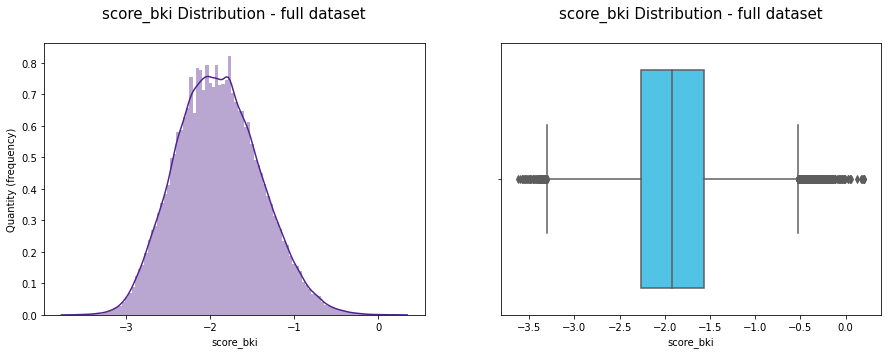

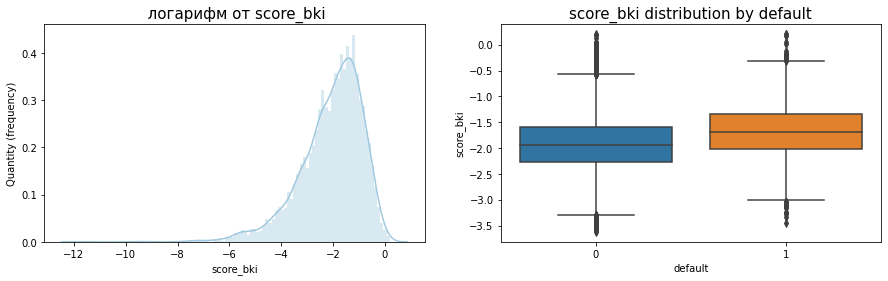

Q1: 50.0
Q3: 60.0
IQR: 10.0 
Граница выбросов: [35.0, 75.0]
Пропущено значений: 0


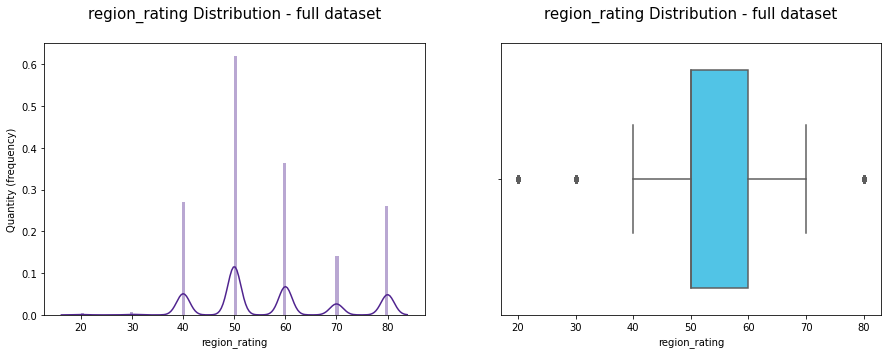

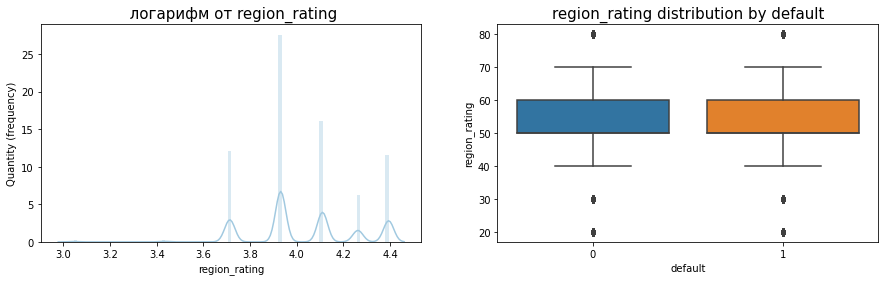

Q1: 2.0
Q3: 4.0
IQR: 2.0 
Граница выбросов: [-1.0, 7.0]
Пропущено значений: 0


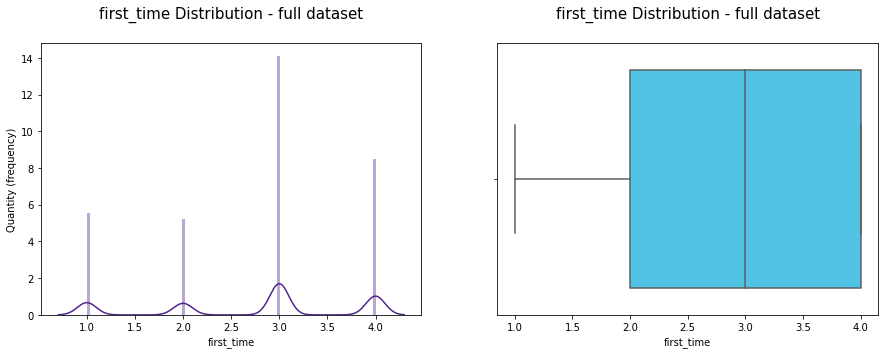

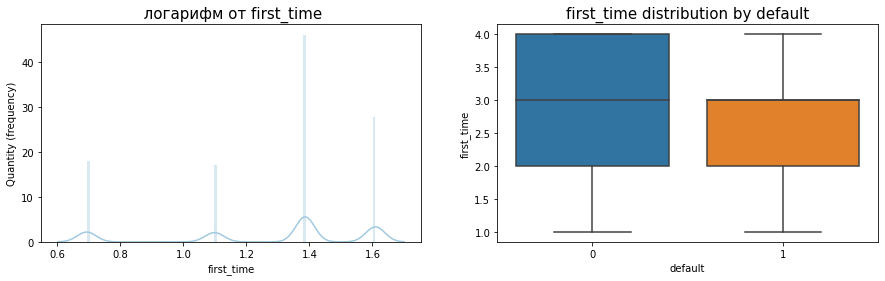

In [10]:
# Рассмотрим распределение числовых данных

for i in num_cols:
    IQR(df, i, 100, 'yes')

 Наблюдаем у большинства числовых признаков правый хвост, эти признаки нужно будет стандартизировать. Также видим, что логарифмирование многих признаков хорошо сглаживает распределение данных. Выбросы есть во всех признаках кроме region_rating, first_time, age. 

In [11]:
# Смотрим на корреляцию до 

print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'bki_request_cnt']).astype('float64'))

# Заменяем выбросы в признаке decline_app_cnt на нижний квантиль 

df = fill_quantile(df, 'bki_request_cnt', 0.75)

# Смотрим на корреляцию после

print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'bki_request_cnt']).astype('float64'))

0.0615225129151954
0.05762101191717876


 Корреляция с целевой переменной уменьшилась, но незначительно.

Q1: 0.0
Q3: 3.0
IQR: 3.0 
Граница выбросов: [-4.5, 7.5]
Пропущено значений: 0


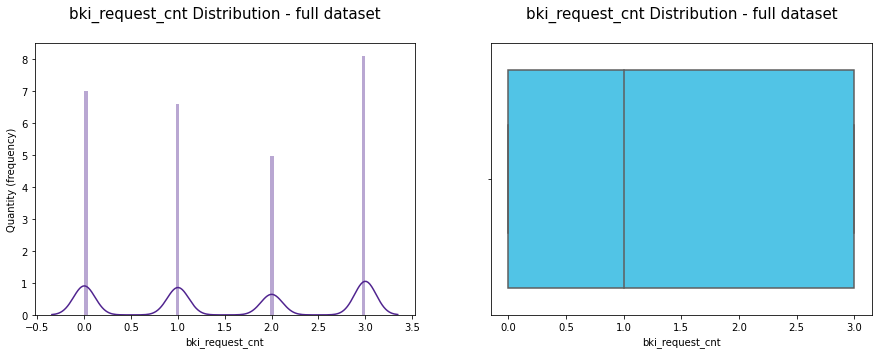

''

In [12]:
# Посмотрим, что получилось
IQR(df, 'bki_request_cnt', 80)

In [13]:
# Попробуем нормальзовать данные в decline_app_cnt 

scaler = MinMaxScaler()
Ranking_norm = scaler.fit_transform(df.loc[:,['decline_app_cnt']]) 
df.loc[:, ['decline_app_cnt']] = Ranking_norm

Q1: 0.0
Q3: 0.0
IQR: 0.0 
Граница выбросов: [0.0, 0.0]
Пропущено значений: 0


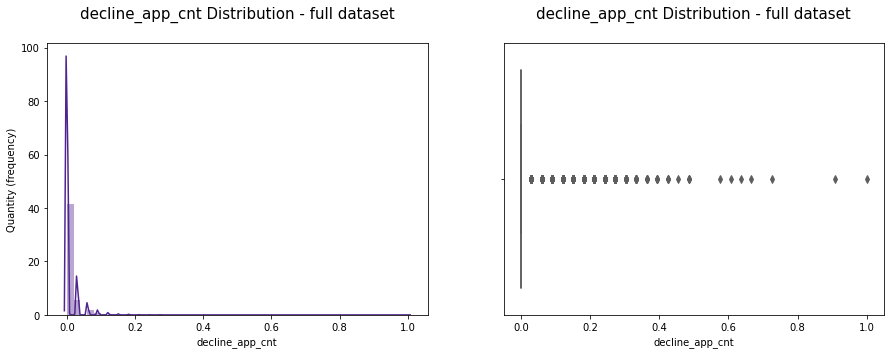

''

In [14]:
IQR(df, 'decline_app_cnt', 50)

In [15]:
# Посмотрим на корреляцию

print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'decline_app_cnt']).astype('float64'))

0.09245536420330949


''

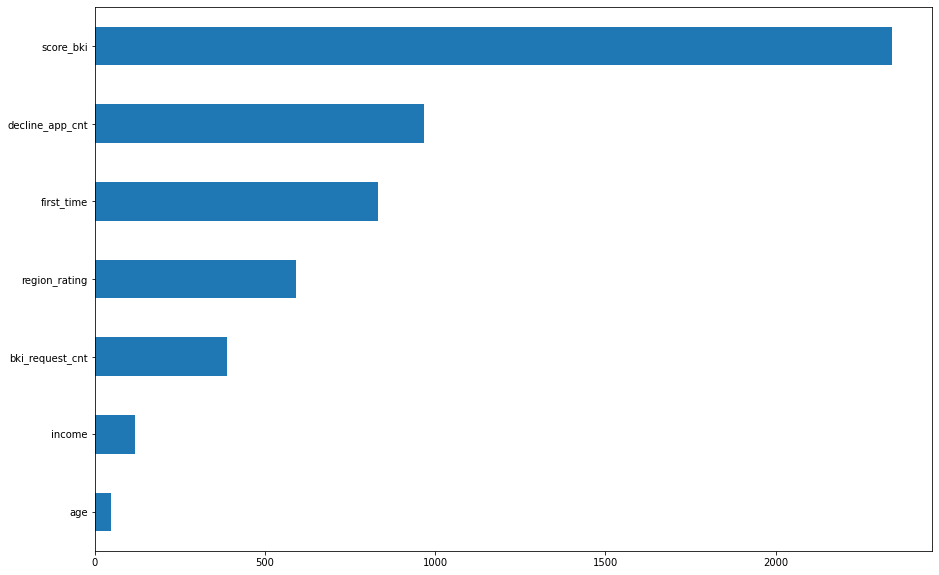

In [16]:
# Рассматриваем важность признаков с помощью функции mutual_info_classif
important_cols(num_cols, df)

Видим, что score_bki значительно более значимый чем другие признаки, а также видим что income и age практически не значимы.

In [17]:
# Посмотрим корреляцию 'income' и 'age'

print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'income']).astype('float64'))
print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'age']).astype('float64'))

-0.03173549858470263
-0.019169365430152754


In [18]:
# Попробуем прологорифмировать age и income

df['age'] = np.log(df['age'])
df['income'] = np.log(df['income'])

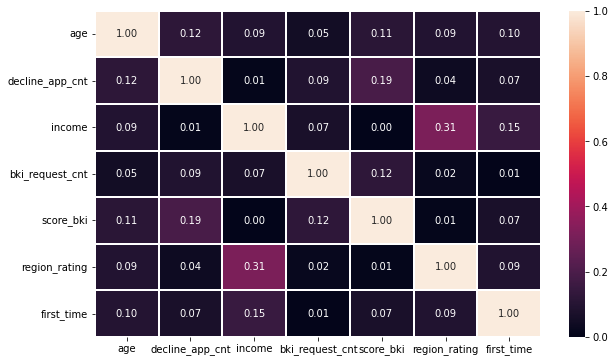

In [19]:
# Построим матрицу корреляций для числовых признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

Нет сильных корреляций, поэтому оставим все как есть.

# Категориальные признаки

In [20]:
#Преобразуем дату в формат datatime

df['app_date'] = pd.to_datetime(df['app_date'])

# У нас выборка оказалась за первые 4 месяца года, месяцы и оставим, как признак

df['app_date'] = df['app_date'].apply(lambda x: x.month)

Значение моды: 0    SCH
dtype: object


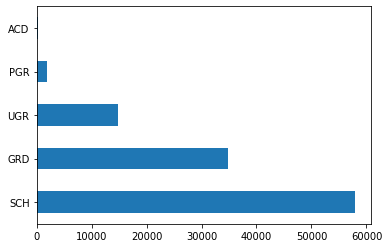

In [21]:
# Смотрим распределения значений и ищем моду для заполнения пропусков в признаке 'education'

df['education'].value_counts().plot.barh()
print('Значение моды:', df.education.mode())

In [22]:
# заменяем NaN на самое частое значение SCH

df['education'] = df['education'].fillna('SCH')

# Так как учеба - категориальное значение, его можно выразить в числах для дальнейшей работы

education_grade = ["SCH", "UGR", "GRD", "PGR", "ACD"]
df["education"] = OrdinalEncoder(categories=[education_grade]).fit_transform(df[["education"]]).astype(int)

# Посмотрим, что получилось

df.education.unique()

array([2, 0, 1, 3, 4])

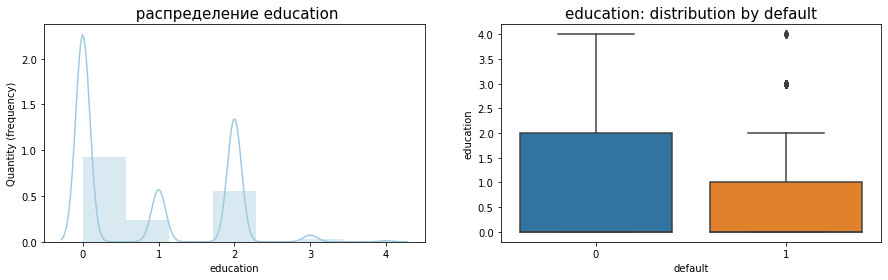

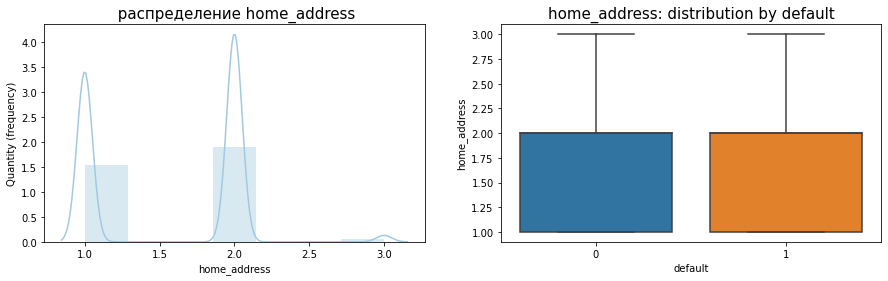

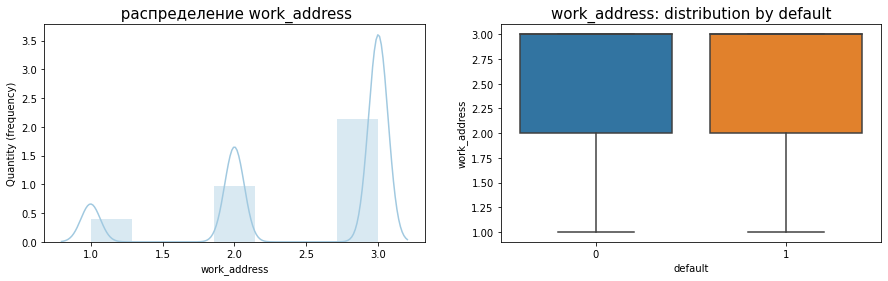

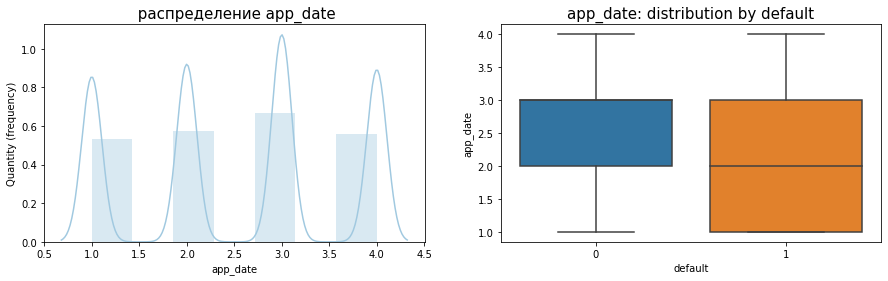

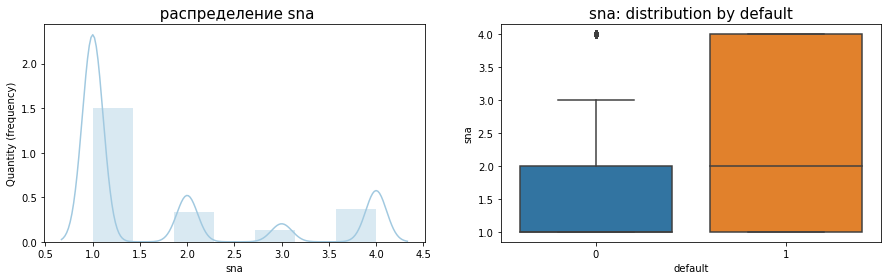

In [23]:
#Рассмотрим распределение категориальных признаков и их влияние на целевой признак

for i in cat_cols:
  category(df, i)

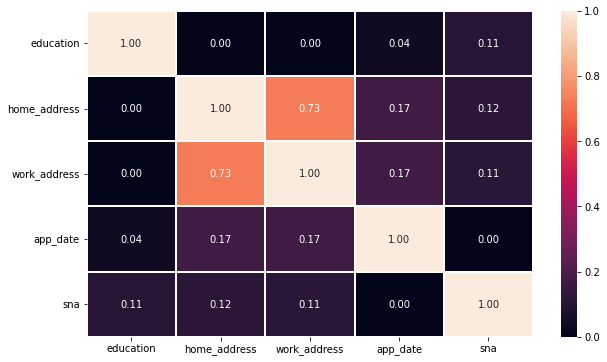

In [24]:
# Построим матрицу корреляций для категориальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

Видим что есть сильная корреляция между work_address и home_address, посмотрим какая менее важная и удалим ее

<AxesSubplot:>

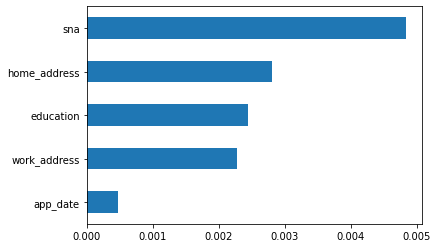

In [25]:
# Рассматриваем значимость категориальных признаков
imp_cat = Series(mutual_info_classif(df[cat_cols], df['default'],
                                     discrete_features = True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [26]:
print(df.loc[:,'default'].astype('float64').corr(df.loc[:,'work_address']).astype('float64'))

0.06473272757898497


In [27]:
# Удаляем рабочий адрес

df = df.drop(columns='work_address')
cat_cols = list(set(cat_cols) - set(['work_address']))

# Бинарные признаки

In [28]:
# Кодируем бинарные признаки

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,foreign_passport,sample,default
0,74835,3,2,1,3.367296,1,1,0.000000,0,-2.271884,3.0,50,1,10.819778,1,4,0,0,0
1,17527,1,0,0,3.663562,0,0,0.151515,0,-1.504999,2.0,50,1,8.517193,4,3,0,0,0
2,75683,3,1,1,3.912023,1,1,0.000000,0,-1.691339,1.0,50,1,10.308953,1,3,1,0,0
3,26883,2,0,1,4.025352,0,0,0.000000,0,-2.374182,1.0,40,1,9.740969,1,3,0,0,0
4,28862,2,2,0,3.637586,0,0,0.000000,0,-2.487502,0.0,80,2,11.695247,1,3,0,0,0


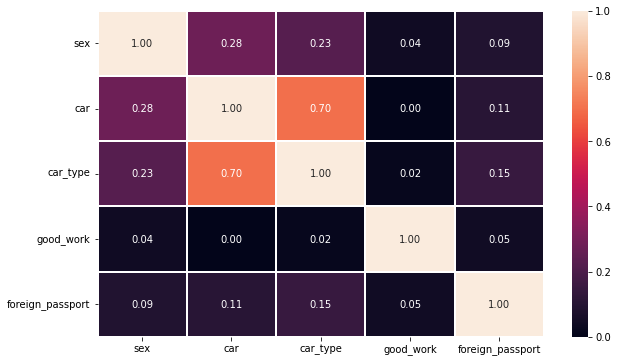

In [29]:
# Построим матрицу корреляций для категориальных признаков:
f = plt.subplots(figsize=(10, 6))
sns.heatmap(df.query('sample == 1')[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

Видим сильную корреляцию между признками car и car_type. Посмотрим какой их них менее важная и удалим ее.

<AxesSubplot:>

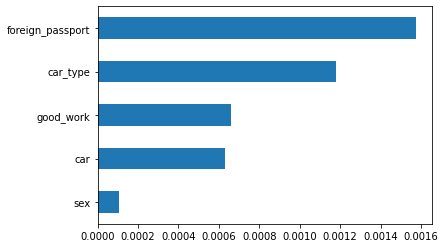

In [30]:
# Рассматриваем значимость бинарных признаков
imp_cat = Series(mutual_info_classif(df[bin_cols], df['default'],
                                     discrete_features = True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [31]:
# Создадим новый признак но основании двух car и car_type

df['car+car_type'] = df['car']+df['car_type']

# Закодируем новую колонку

label_encoder = LabelEncoder()
df['car+car_type'] = label_encoder.fit_transform(df['car+car_type'])
df = df.drop(columns=['car', 'car_type'])
bin_cols = list(set(bin_cols) - set(['car', 'car_type']))

# Подготовка данных для обучения

In [32]:
# Добавим полиноминальные признаки

pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df, how='left')
num_cols = num_cols + poly_cols

''

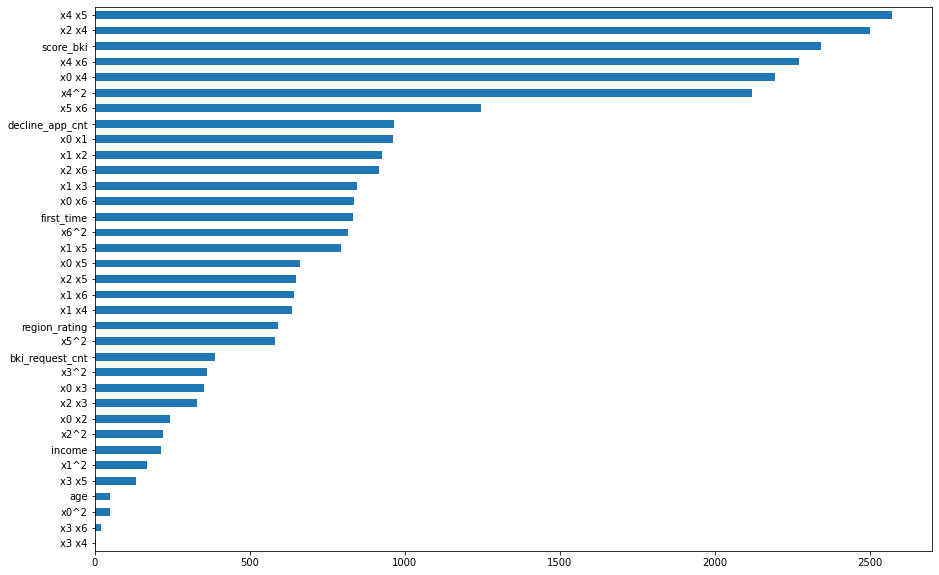

In [33]:
important_cols(num_cols, df)

In [34]:
imp_num = pd.Series(f_classif(df.query('sample == 1')[num_cols], df.query('sample == 1')['default'])[0], index = num_cols)

# Оставляем 80% самых важных признаков из числовых, а 20 отсекаем

final_num_cols = list(imp_num.sort_values(ascending=False).keys()[:int(len(imp_num)*0.8)])
final_num_cols

['x4 x5',
 'x2 x4',
 'score_bki',
 'x4 x6',
 'x0 x4',
 'x4^2',
 'x5 x6',
 'decline_app_cnt',
 'x0 x1',
 'x1 x2',
 'x2 x6',
 'x1 x3',
 'x0 x6',
 'first_time',
 'x6^2',
 'x1 x5',
 'x0 x5',
 'x2 x5',
 'x1 x6',
 'x1 x4',
 'region_rating',
 'x5^2',
 'bki_request_cnt',
 'x3^2',
 'x0 x3',
 'x2 x3',
 'x0 x2',
 'x2^2']

In [35]:
# dammy кодирования
df = pd.get_dummies(df, columns=cat_cols)

In [36]:
bin_cat_cols = list(df.columns)
for x in poly_cols:
    bin_cat_cols.remove(x)
    
# удалим лишние столбцы
bin_cat_cols.remove('client_id')
bin_cat_cols.remove('default')
bin_cat_cols.remove('sample')

<AxesSubplot:>

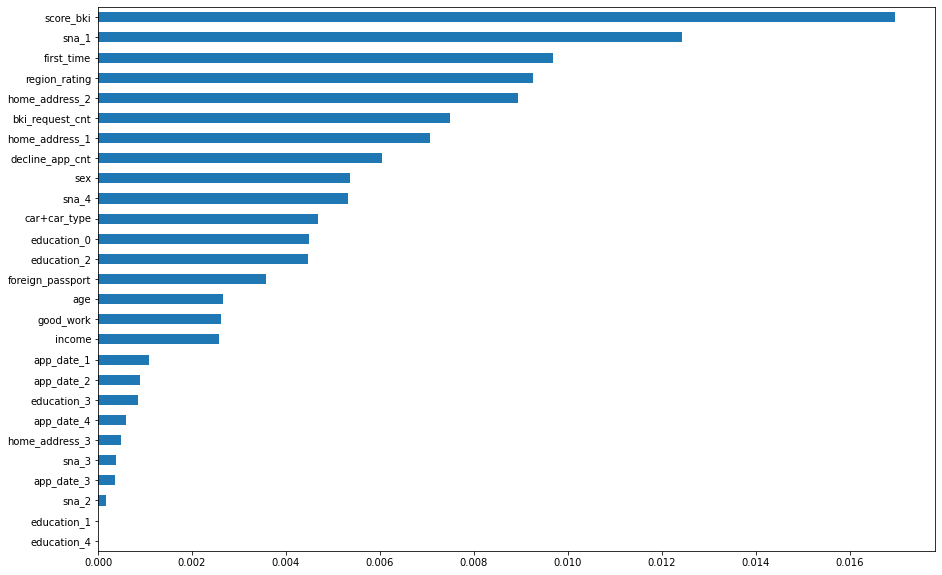

In [37]:
imp_cat = pd.Series(mutual_info_classif(df.query('sample == 1')[bin_cat_cols], df.query('sample == 1')['default']), index = bin_cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',figsize=(15,10))

In [38]:
# Оставляем 80% самых важных признаков из категориальных и бинарных, а 20 отсекаем

final_bin_cat_cols = list(imp_cat.sort_values(ascending=False).keys()[:int(len(imp_cat)*0.8)])
final_bin_cat_cols

['score_bki',
 'sna_1',
 'first_time',
 'region_rating',
 'home_address_2',
 'bki_request_cnt',
 'home_address_1',
 'decline_app_cnt',
 'sex',
 'sna_4',
 'car+car_type',
 'education_0',
 'education_2',
 'foreign_passport',
 'age',
 'good_work',
 'income',
 'app_date_1',
 'app_date_2',
 'education_3',
 'app_date_4']

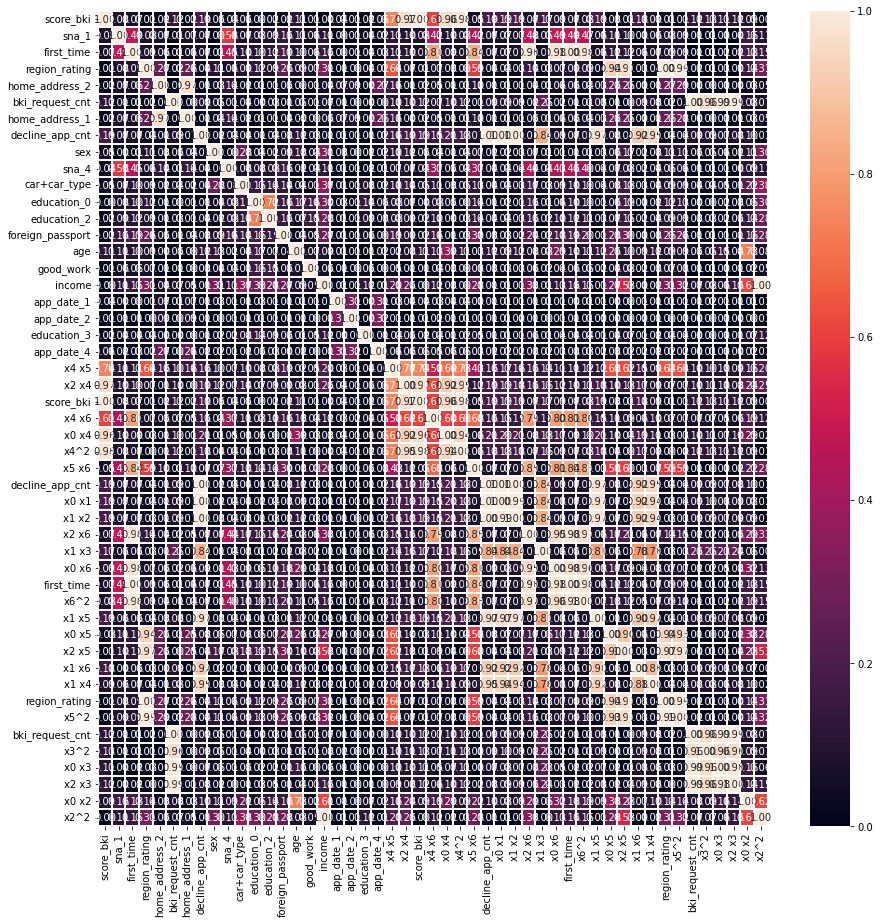

In [39]:
f = plt.subplots(figsize=(15, 15))
sns.heatmap(df.query('sample == 1')[final_bin_cat_cols + final_num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

In [40]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(df[final_num_cols].values)
df[final_num_cols] = X_num

In [41]:
# Разделим объединенный датасет на тренировочный и тестовый:
train = df.query('sample == 1')[final_bin_cat_cols + final_num_cols]
test = df.query('sample == 0')[final_bin_cat_cols + final_num_cols]

In [42]:
# Объединяем
X = train.values
Y = df.query('sample == 1').default.values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

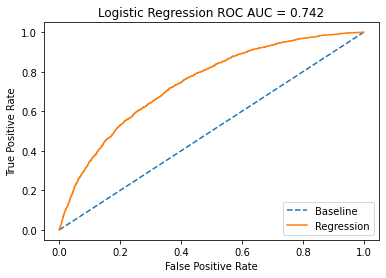

In [44]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', C=1.0, penalty='l2')
model.fit(X_train, y_train)

probs = model.predict(X_test)
pred_probs = model.predict_proba(X_test)


fpr, tpr, threshold = roc_curve(y_test, pred_probs[:,1])
roc_auc = roc_auc_score(y_test, pred_probs[:,1])

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [45]:
print('accuracy_score:', accuracy_score(y_test, probs))
print('precision_score:', precision_score(y_test, probs))
print('recall_score:', recall_score(y_test, probs))
print('f1_score:', f1_score(y_test, probs))
сf_mtx = confusion_matrix(y_test, probs)
print()
print('confusion matrix:', '\n', сf_mtx)
tn, fp, fn, tp = сf_mtx.ravel()
print()
print('Предсказано невозращение долга клиентом, вернувшим долг: {} \n\
 или {}% от всех вернувших \n'.format(fp, round((fp/(fp+tn))*100, 2)))
print('Предсказан возврат долга клиентом, не вернувшим долг: {} \n\
или {}% от всех не вернувших\n'.format(fn, 
                                        round((1-recall_score(y_test,probs))*100, 2)))
print()
print('roc_auc_score:', roc_auc_score(y_test, pred_probs[:, 1]))

accuracy_score: 0.6663956639566395
precision_score: 0.22264015762135053
recall_score: 0.6803503010399562
f1_score: 0.33549257759784074

confusion matrix: 
 [[8593 4340]
 [ 584 1243]]

Предсказано невозращение долга клиентом, вернувшим долг: 4340 
 или 33.56% от всех вернувших 

Предсказан возврат долга клиентом, не вернувшим долг: 584 
или 31.96% от всех не вернувших


roc_auc_score: 0.742003617566532


In [46]:
sub_test = test.values
submission = df.query('sample == 0')[['client_id', 'default']]
submission['default'] = model.predict_proba(sub_test)[:,1]
display(submission.sample(10))

,client_id,default
11453,100207,0.377409
22609,33298,0.337757
22855,96075,0.088232
1542,29189,0.501390
34569,105995,0.363281
12335,59291,0.711599
8078,104704,0.099109
20387,99489,0.606643
4875,26088,0.047973
14739,69898,0.858153


In [47]:
submission.to_csv('submission.csv', index=False)